In [2]:
import sys
sys.path.append("../")

from rbm import fasta_read, get_beta_and_W, all_weights, RBM
import analysis_methods as am

from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import subprocess as sp
import matplotlib.image as mpimg

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


In [3]:
# Directory of Stored RBMs
mdir = "/mnt/D1/globus/cov_trained_rbms/"
rounds = [f"r{i}" for i in range(1, 13)]
rounds_w = [f"r{i}_w" for i in range(1, 13)]

#### Generate Weights

In [6]:
# Did not train rounds 1 or 2. 2 crashed and 1 takes too much memory

# generate weights in respective
for rid, round in enumerate(rounds_w[2:]):
    # if rid > 0:
    #     break
    checkp, version_dir = am.get_checkpoint_path(round, rbmdir=mdir)
    tmp = RBM.load_from_checkpoint(checkp)
    all_weights(tmp, version_dir +round+"_weights", 5, 1, 6, 2, "dna")

../rbm_utils.py:313: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  
../rbm_utils.py:505: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


In [8]:
def assign(x):
    if x < 10:
        return "L" # low
    elif x < 50:
        return "M" # medium
    else:
        return "H" # High

# Stores all data in a dictionary ("data")
all_data = am.fetch_data(rounds, dir="../../cov", assignment_function=assign, threads=12)

Process Time 13.729238510131836
Process Time 6.422047138214111
Process Time 0.5324947834014893
Process Time 0.38591623306274414
Process Time 1.5125486850738525
Process Time 1.0572867393493652
Process Time 1.8484504222869873
Process Time 0.6239931583404541
Process Time 0.1648387908935547
Process Time 0.4283914566040039
Process Time 0.2109980583190918
Process Time 0.46900320053100586


In [5]:
# Generate Sequence Logo for Each round
paths_u, paths_w = [], []
for r in rounds:
    paths_u.append(am.seq_logo(all_data[all_data["round"] == r], f"{r}_seqlogo", weight=False, outdir="./generated/"))
    paths_w.append(am.seq_logo(all_data[all_data["round"] == r], f"{r}_w_seqlogo", weight=True, outdir="./generated/"))

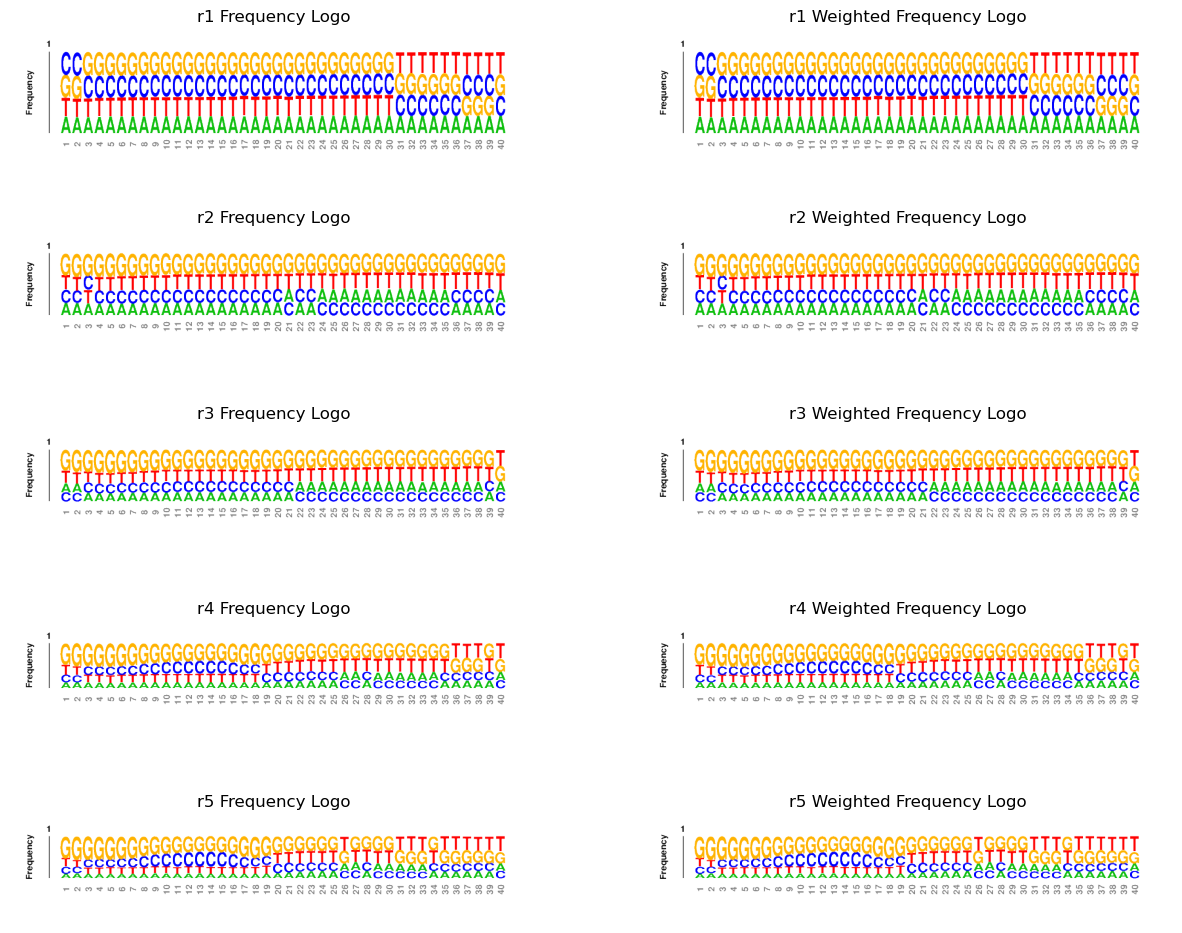

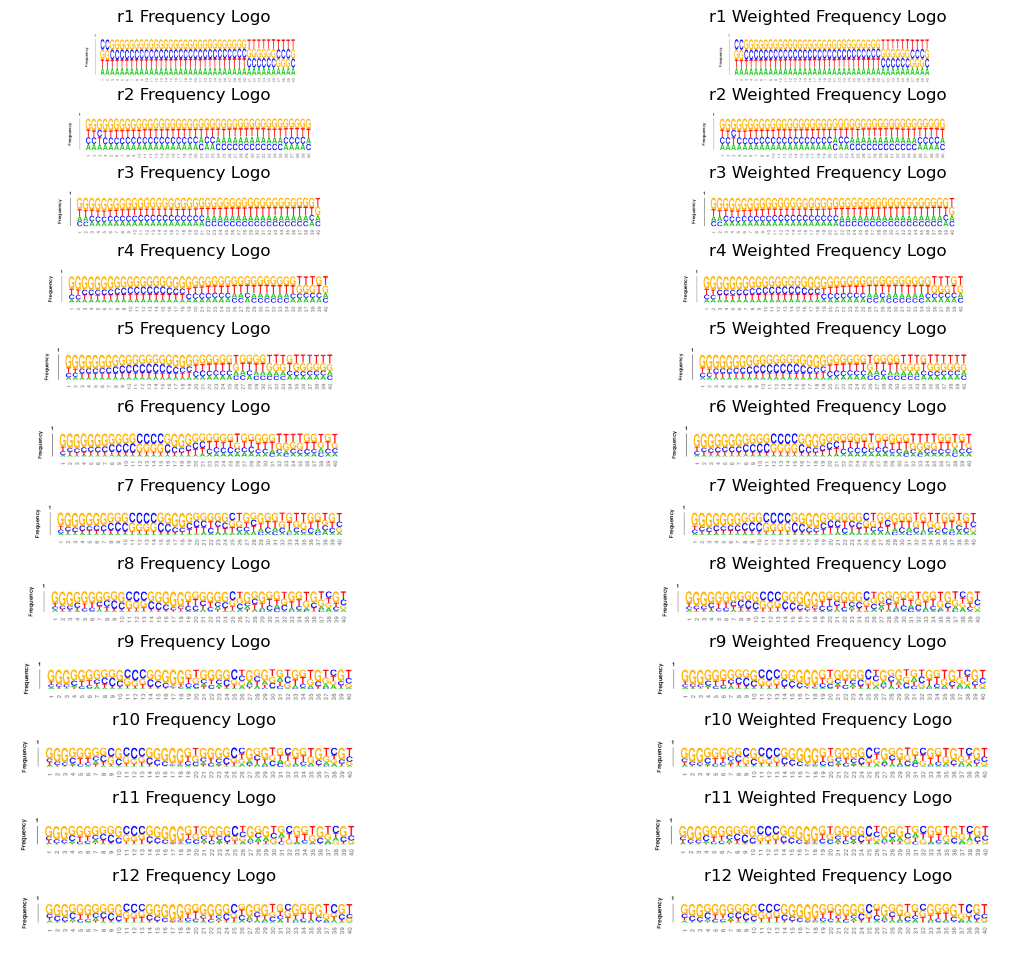

In [7]:
# Seq Logo showing Frequency of Each Amino Acid at each position
fig, axs = plt.subplots(len(rounds), 2)
fig.set_size_inches(15, 12)

for rid, r in enumerate(rounds):
    img1 = mpimg.imread(f"{paths_u[rid]}.freq.png")
    img2 = mpimg.imread(f"{paths_w[rid]}.freq.png")
    axs[rid][0].imshow(img1)
    axs[rid][1].imshow(img2)
    axs[rid][0].axis("off")
    axs[rid][1].axis("off")
    axs[rid][0].set_title(f"{r} Frequency Logo")
    axs[rid][1].set_title(f"{r} Weighted Frequency Logo")

plt.show()

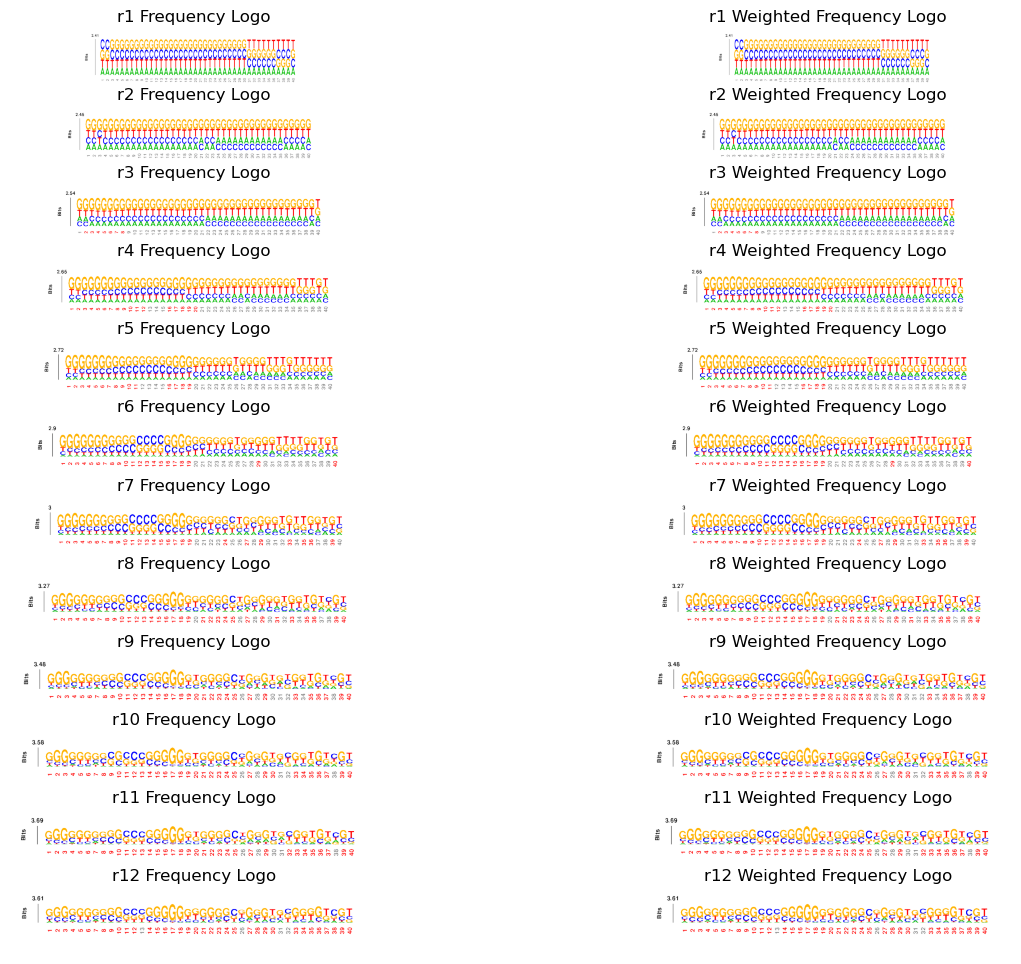

In [8]:
# Seq Logo showing Information of Each Amino Acid at each position
fig, axs = plt.subplots(len(rounds), 2)
fig.set_size_inches(15, 12)

for rid, r in enumerate(rounds):
    img1 = mpimg.imread(f"{paths_u[rid]}.info.png")
    img2 = mpimg.imread(f"{paths_u[rid]}.info.png")
    axs[rid][0].imshow(img1)
    axs[rid][1].imshow(img2)
    axs[rid][0].axis("off")
    axs[rid][1].axis("off")
    axs[rid][0].set_title(f"{r} Frequency Logo")
    axs[rid][1].set_title(f"{r} Weighted Frequency Logo")

plt.show()

In [ ]:
def count_dist(data_w_counts, title):
    fig, axs = plt.subplots(2, 1)
    sns.histplot(data_w_counts, ax=axs[0], x="round", hue="assignment", multiple="fill", palette="rocket", stat="percent")
    sns.histplot(data_w_counts, ax=axs[1], x="round", hue="assignment", multiple="stack", palette="rocket", stat="count")
    # sns.barplot(data=data_w_counts, ax=axs[0], x="round", y="copynum")
    plt.suptitle(title)
    plt.show()

count_dist(all_data, "Unique Sequence Count Distribution")

In [4]:
# Low count == 1, Med count < 10, High count >= 10
# calculate likelihoods from last round rbm only
checkp, v_dir = am.get_checkpoint_path("r11_w", rbmdir=mdir)
r11_rbm = RBM.load_from_checkpoint(checkp)

# this takes awhile, might be something I optimize further in the future
# am.generate_likelihoods(rounds[2::2], r11_rbm, all_data, "r11_w_v0")

In [5]:
r11_likelihoods = am.get_likelihoods("./generated/r11_w_v0.json")

In [19]:
r11_likelihoods['likelihoods'].keys()

dict_keys(['r3', 'r5', 'r7', 'r9', 'r11'])

In [16]:
r11_likelihoods['likelihoods']["r3_w"]

[]

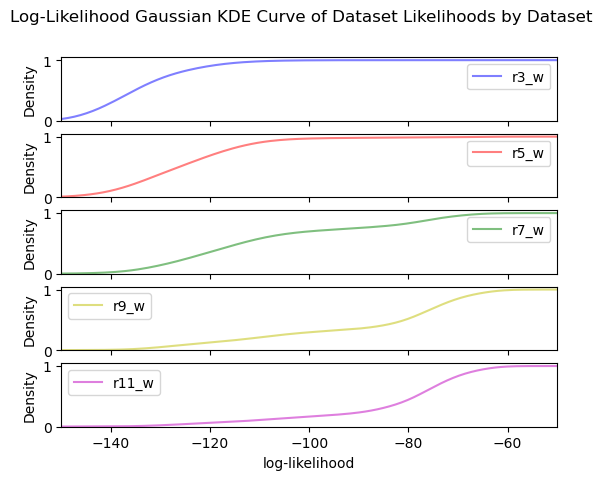

In [20]:
# Plot Likelihoods of Each batch of Data
am.plot_likelihoods(r11_likelihoods["likelihoods"], rounds[2::2], rounds_w[2::2], xlim=(-150, -50), cdf=True)

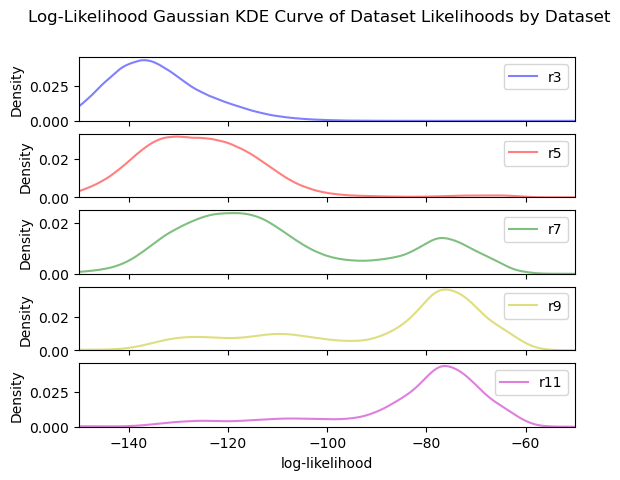

In [21]:
am.plot_likelihoods(r11_likelihoods["likelihoods"], rounds[2::2], rounds[2::2], xlim=(-150, -50), cdf=False)

In [24]:
def shaded_kde_curve(ax, path, xmin, xmax, color):
    vertices = [ (x, y) for x, y in path.vertices if xmin < x < xmax]
    vertices.insert(0, (xmin, 0.))
    vertices.append((xmax, 0.))
    xfill, yfill = zip(*vertices)
    ax.fill(xfill, yfill, color)

def color_subplot(ax, color):
    for spine in ax.spines.values():
        spine.set_edgecolor(color)

def seqlogo_subplot(ax, path, type="info"):
    img = mpimg.imread(f"{path}.{type}.png")
    ax.imshow(img, interpolation="nearest")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_xticklabels([])



# bounds listed in ascending order
def multi_peak_seq_log_fig(data, likelihoods, round, bounds, weight=False, title=None, xlim=None):
    data_subsets, seqlogo_paths = [], []
    for iid,  i in enumerate(bounds):
        sub = am.data_subset(data, likelihoods, round, i[0], i[1])
        seqlogo_paths.append(am.seq_logo(sub, f"peak{iid+1}_likeli_{round}", weight=weight, outdir="./generated/"))
        data_subsets.append(sub)

    peak_num = len(bounds)
    gs_kw = dict(width_ratios=[1 for x in range(peak_num)], height_ratios=[1, 1])
    fig, axd = plt.subplot_mosaic([['top' for x in range(peak_num)], [f'lower{x}' for x in range(peak_num)]],
                                  gridspec_kw=gs_kw, figsize=(15, 5), constrained_layout=False)

    axd["top"].set_xlim(*xlim)
    sns.kdeplot(likelihoods[round], ax=axd["top"])

    path = axd["top"].get_children()[0].get_path()

    for iid, i in enumerate(bounds):
         shaded_kde_curve(axd["top"], path, i[0], i[1], am.supported_colors[iid])

    axd["top"].set_xlabel("log-likelihood")
    for iid, i in enumerate(bounds):
        color_subplot(axd[f"lower{iid}"], am.supported_colors[iid])
        seqlogo_subplot(axd[f"lower{iid}"], seqlogo_paths[iid])

    if title is None:
        fig.suptitle(title)
    else:
        fig.suptitle(f"Composition of peaks across RBM Likelihood of Round{round}")

    plt.show()



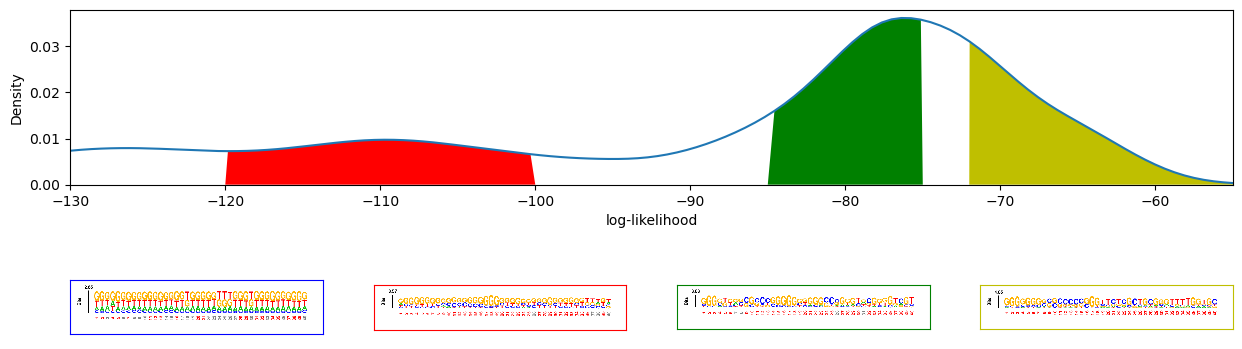

In [26]:
multi_peak_seq_log_fig(all_data, r11_likelihoods["likelihoods"], "r9", [[-140, -130],[-120, -100], [-85, -75], [-72, 0]], weight=False, xlim=(-130, -55))

In [6]:
# calculate likelihoods from last round rbm only
checkp, v_dir = am.get_checkpoint_path("r3_w", rbmdir=mdir)
r3_rbm = RBM.load_from_checkpoint(checkp)

# this takes awhile, might be something I optimize further in the future
# am.generate_likelihoods(rounds[2::2], r3_rbm, all_data, "r3_v0_w_odd_rounds")

In [7]:
r3_likelihoods = am.get_likelihoods("./generated/r3_v0_w_odd_rounds.json")

In [31]:
r3_likelihoods["likelihoods"]["r3"]

[-22.03927180896727,
 -24.594212476439026,
 -13.804426117542022,
 -17.257469158145142,
 -24.929244905005277,
 -12.66074790290699,
 -23.844365123342726,
 -24.359276459388752,
 -20.826076568438253,
 -24.383598310844377,
 -11.515664381669353,
 -17.47591172322703,
 -17.85583535055744,
 -16.62732940787251,
 -21.33300046689527,
 -21.92947714620854,
 -19.938976197007122,
 -18.76219741060862,
 -21.368547116207083,
 -19.842269172734433,
 -23.526352424425966,
 -19.27773534849979,
 -15.627737934452199,
 -21.376033176830788,
 -20.956078765324037,
 -19.317165178213088,
 -19.872211787440932,
 -25.004007143626353,
 -25.48186095727874,
 -19.599106668067094,
 -16.003470557707004,
 -15.930007660996523,
 -18.47142770129824,
 -23.077056213708914,
 -17.24201501617253,
 -17.082942528555492,
 -14.600473056242947,
 -21.879283542308315,
 -20.81052181554793,
 -17.897309254165606,
 -18.967501624666937,
 -17.785719790621812,
 -17.9561896765735,
 -16.98374039631392,
 -19.659475419491287,
 -16.810656715726566,
 -21

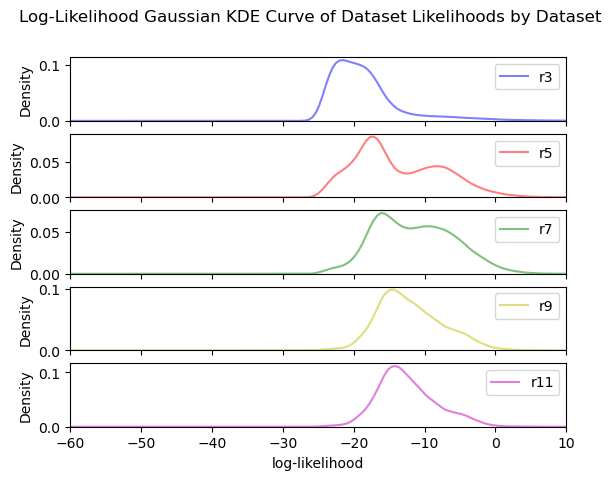

In [34]:
# assign likelihoods in new pd dataframe
am.plot_likelihoods(r3_likelihoods["likelihoods"], rounds[2::2], rounds[2::2], xlim=(-60, 10))

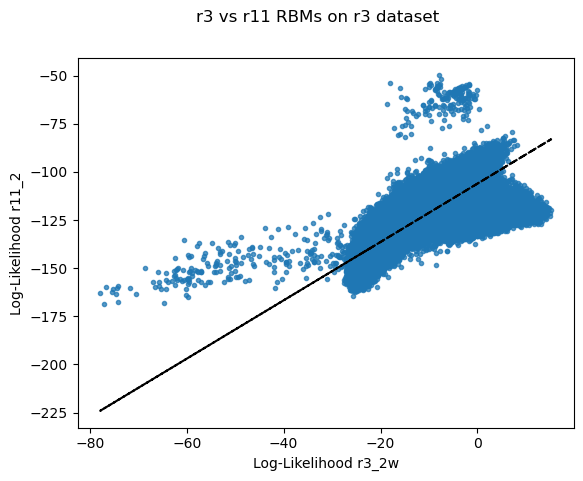

In [35]:
am.compare_likelihood_correlation(r3_likelihoods["likelihoods"]["r3"], r11_likelihoods["likelihoods"]["r3"], "r3 vs r11 RBMs on r3 dataset", ["r3_2w", "r11_2"])

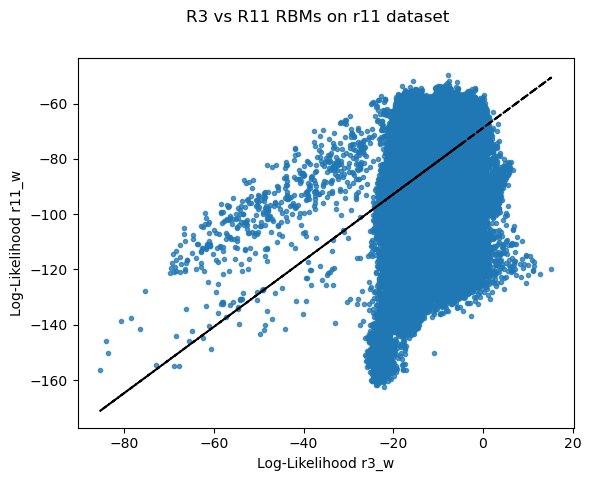

In [36]:
am.compare_likelihood_correlation(r3_likelihoods["likelihoods"]["r11"], r11_likelihoods["likelihoods"]["r11"], "R3 vs R11 RBMs on r11 dataset", ["r3_w", "r11_w"])

In [29]:
exp_seqs = {
    "SP5": 'ACCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTTGGT',
    "SP6": "CCCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTTGGT",
    "SP7": "CGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGCCGGGT",
    "SP6C": 'CCCATGGTAGGTATTGCTTGGTAGCGATAGTGGGCTTGGT',
    "SP634":  "CCCATGGTAGGTATTGCTTGGTAGGGATAGTGGG------",
    "SP634G": "CCCATGGTAGGTATTGGTTGGTAGGGATAGTGGG------",
    "SP634C": "CCCATGGTAGGTATTGCTTGGTAGCGATAGTGGG------",
    "SP634A": "CCCATGGTAGGTATTGCATGGTAGGGATAGTGGG------",
    "SP630":  "---CATGGTAGGTATTGCATGGTAGGGATAGTG-------",
    "SP619":  "------------TATTGCATGGTAGGGATAG---------",
}

keys = exp_seqs.keys()
values = exp_seqs.values()
new_exp_seqs = {}
set_nuc = "A"
for i in keys:
    seq = exp_seqs[i]
    while "-" in seq:
        new_char = np.random.choice(["A", "C", "G", "T"])
        # new_char = set_nuc
        ind = seq.find("-")
        seq = seq[:ind] + new_char + seq[ind+1:]
    new_exp_seqs[i] = seq

rand_exp_seqs = new_exp_seqs

exp_A_seqs = {
    "SP5":       'ACCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTTGGT',
    "SP6":       "CCCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTTGGT",
    "SP7":       "CGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGCCGGGT",
    "SP6C":      'CCCATGGTAGGTATTGCTTGGTAGCGATAGTGGGCTTGGT',
    "SP634":     "CCCATGGTAGGTATTGCTTGGTAGGGATAGTGGGAAAAAA",
    "SP634G":    "ACCATGGTAGGTATTGGTTGGTAGGGATAGTGGGAAAAAA",
    "SP634C":    "CCCATGGTAGGTATTGCTTGGTAGCGATAGTGGGAAAAAA",
    "SP634A":    "CCCATGGTAGGTATTGCATGGTAGGGATAGTGGGAAAAAA",
    "SP630":     "AACATGGTAGGTATTGCATGGTAGGGATAGTGAAAAAAAA",
    "SP619":     "AAAAAAAAAAATATTGCATGGTAGGGATAGAAAAAAAAAA",
    "r12_align": "AGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGTTGATT"
}


rand_exp_set = {'id':list(new_exp_seqs.keys()), 'sequence':list(new_exp_seqs.values())}
exp_set = {'id':list(exp_seqs.keys()), 'sequence':list(exp_seqs.values())}
exp_A_set = {'id':list(exp_A_seqs.keys()), 'sequence':list(exp_A_seqs.values())}
exp_pd = pd.DataFrame(exp_set)
exp_A_pd = pd.DataFrame(exp_A_set)
rand_exp_pd = pd.DataFrame(rand_exp_set)

In [31]:
exp_3_seqs, exp_3_likelis = r3_rbm.predict(exp_pd)
exp_3_A_seqs, exp_3_A_likelis = r3_rbm.predict(exp_A_pd)
exp_11_seqs, exp_11_likelis = r11_rbm.predict(exp_pd)
exp_11_A_seqs, exp_11_A_likelis = r11_rbm.predict(exp_A_pd)
exp_3_rand_seqs, exp_3_rand_likelis = r3_rbm.predict(rand_exp_pd)
exp_11_rand_seqs, exp_11_rand_likelis = r11_rbm.predict(rand_exp_pd)

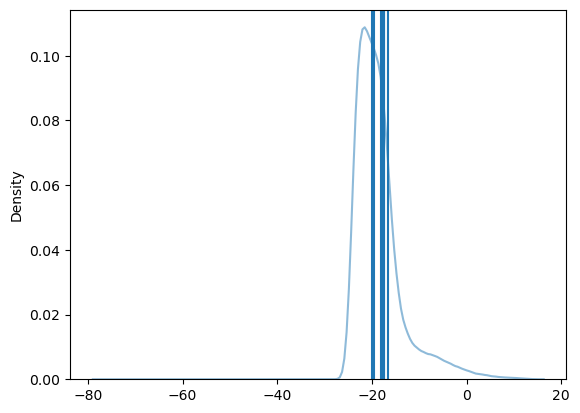

In [32]:
fig, axs = plt.subplots(1, 1)
y = sns.kdeplot(r3_likelihoods["likelihoods"]["r3"], shade=False, alpha=0.5, ax=axs)
for likeli in exp_3_rand_likelis:
    plt.axvline(likeli)
plt.show()

In [33]:
for i in range(len(exp_seqs)):
    print(exp_3_rand_seqs[i], exp_3_rand_likelis[i])

ACCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTTGGT -17.425582672975764
CCCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTTGGT -17.70086075310391
CGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGCCGGGT -17.380955288573347
CCCATGGTAGGTATTGCTTGGTAGCGATAGTGGGCTTGGT -19.47336293417507
CCCATGGTAGGTATTGCTTGGTAGGGATAGTGGGTCATGG -18.018936177889657
CCCATGGTAGGTATTGGTTGGTAGGGATAGTGGGTCTTTG -16.64765510701696
CCCATGGTAGGTATTGCTTGGTAGCGATAGTGGGTTTCTG -19.724217076120794
CCCATGGTAGGTATTGCATGGTAGGGATAGTGGGCATCGG -19.731608150124657
GACCATGGTAGGTATTGCATGGTAGGGATAGTGTAATTCA -19.747626380883247
CGTGGTGGGCCCTATTGCATGGTAGGGATAGTCATCCGGC -20.052876906019378


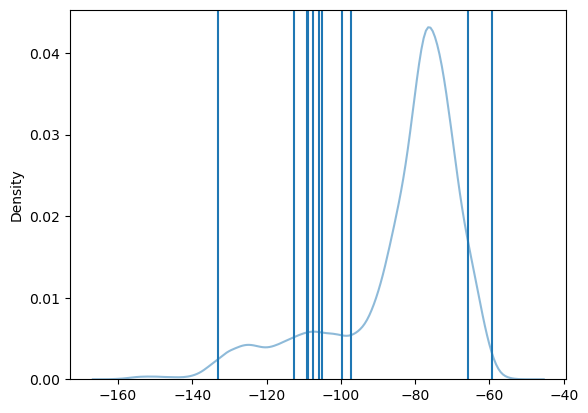

In [23]:
fig, axs = plt.subplots(1, 1)
y = sns.kdeplot(r11_likelihoods["likelihoods"]["r11"], shade=False, alpha=0.5, ax=axs)
for likeli in exp_11_A_likelis:
    plt.axvline(likeli)
plt.show()

In [25]:
for i in range(len(exp_11_A_seqs)):
    print(exp_11_A_seqs[i], exp_11_A_likelis[i])

ACCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTTGGT -97.37184865934154
CCCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTTGGT -99.78000099021153
CGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGCCGGGT -65.77541592613846
CCCATGGTAGGTATTGCTTGGTAGCGATAGTGGGCTTGGT -105.19052405847722
CCCATGGTAGGTATTGCTTGGTAGGGATAGTGGGAAAAAA -106.00025655402149
ACCATGGTAGGTATTGGTTGGTAGGGATAGTGGGAAAAAA -107.46914375112297
CCCATGGTAGGTATTGCTTGGTAGCGATAGTGGGAAAAAA -112.73445658442714
CCCATGGTAGGTATTGCATGGTAGGGATAGTGGGAAAAAA -108.88223044202928
AACATGGTAGGTATTGCATGGTAGGGATAGTGAAAAAAAA -109.09337952353164
AAAAAAAAAAATATTGCATGGTAGGGATAGAAAAAAAAAA -132.99166505465558
AGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGTTGATT -59.2031573263977


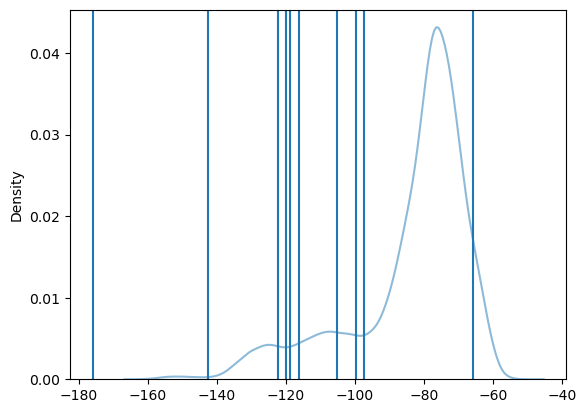

In [26]:
fig, axs = plt.subplots(1, 1)
y = sns.kdeplot(r11_likelihoods["likelihoods"]["r11"], shade=False, alpha=0.5, ax=axs)
for likeli in exp_11_likelis:
    plt.axvline(likeli)
plt.show()

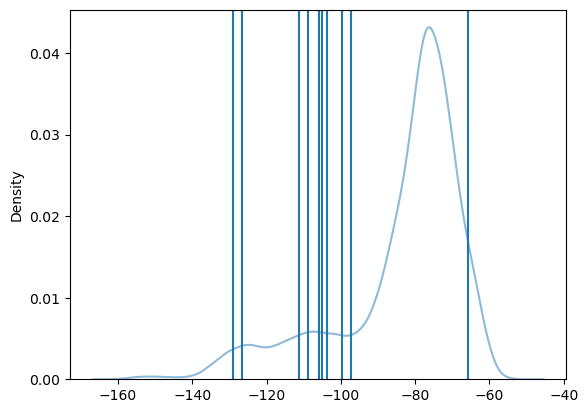

In [34]:
fig, axs = plt.subplots(1, 1)
y = sns.kdeplot(r11_likelihoods["likelihoods"]["r11"], shade=False, alpha=0.5, ax=axs)
for likeli in exp_11_rand_likelis:
    plt.axvline(likeli)
plt.show()

In [22]:
r11_likelihoods.keys()

dict_keys(['likelihoods', 'sequences'])

In [16]:
lik = r11_likelihoods["likelihoods"]["r11"]
seq = r11_likelihoods["sequences"]["r11"]

for lid, l in enumerate(lik):
    if l > -60:
        print(seq[lid])

GGGAGGGAGGGTCGGGGGTACTCGCTGCGGGTTTTGGTGC
GGGGGGGGGCCCCCCCGGTTCTCGCTGCGGGGTTTGGTGC
TCGCGGGGGGCGGGTCGGGTGCTAGTTCGAGGGGTCGCAG
GGGAGGGAGGGTGGAGGGTTTTCGCTGCGGGTTTTGGTGC
GGGAGGGAGGGTGGGGAGTTCTCGCTGCGGGTTTTGGTGC
GGGAGGGAGGGTGGGGGGTTCTTGCTGCGGGTATTGGTGC
GGGGCGGGCCCCCCCCGGTTCTCGCTGCGGGTTTTGGTGC
GGGGGGGCCCCCCCCCGGTTTTCGCTGCGGGTTTTGGTGC
GGGCGGGAGGGTGGGGGGTTCTCACTGCGGGTTTTGGTGC
TCGCGGGGGGCGGGTCGGGTGCTCGTTCGAGGAGTCGCAG
GGGAGGGAGGGTGGGGGGTTCTCGCTGCGGGTCTTGGTGC
GGGGGGGGGGGGCCCCGGTTCTCGCTGCGGGTTTTGGTGC
GGGAGGCCCCCCCCCCGGTTCTCGCTGCGGGTTTTGGTGC
TCGCGGGGGGCGGGCCGGGTGCTCGTTCGAGGTGTCGCAG
TCGGGGGGGGCGGGTCGGGTGCTCGTTCGAGGGGTCTCAG
TGGCGGGAGGGAGGGGGGTTCTCGCTGCGGGTTTTGGTGC
GGGAGGGAGGGTGGTGGGTTCTCGGTGCGGGTTTTGGTGC
CGGAGGCAGGGTGGGGGGTTCTCGCTGCGGGTTTTGGTGC
GGGCCCGCCCCCCCCCGGTTCTCGCTGCGGGTTTTGGTGC
GGGAGGGGGGGTGAGGGGTTCTCGCTGCGGGTTTTGGTGC
TGGAGGGAGGGTGGGGGGTTCTCGTTGCGGGTTTTGGTGC
GGGCGGGCGGCTCGGGGGTTCTCGCTGCGGGTTTTGGTGC
GGGAGGGAGGGTGGGGGGTTCTCGCTGCGAGTTTTGGTGC
GGGGGCGCGGCCCCCCGGTTCTCGCTGCGGGTTTTGGTGC
TCGCGGGGGGCGGGTC